In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pickle
import random as rnd
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
import sklearn
import statsmodels.api as sm
import xgboost as xgb
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from matplotlib import pyplot
from matplotlib.font_manager import FontProperties
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostRegressor, BaggingClassifier,
                              BaggingRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor, RandomForestRegressor,
                              VotingRegressor)
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       VarianceThreshold, chi2)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import (ElasticNet, HuberRegressor, Lasso,
                                  LinearRegression, RANSACRegressor, Ridge,
                                  SGDRegressor, TheilSenRegressor)
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, log_loss,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (Binarizer, LabelEncoder, MinMaxScaler,
                                   Normalizer, OneHotEncoder,
                                   PolynomialFeatures, StandardScaler,
                                   normalize)
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [3]:
traindf = pd.read_csv('../data/train.csv', index_col="ID")
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
81358,City Hotel,1,59,2017,January,4,23,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,326.0,NaN,0,Transient,87.710520,0,0,Canceled,2016-11-25
18519,Resort Hotel,0,0,2015,November,48,23,1,2,1,0.0,0,BB,PRT,Corporate,Corporate,1,0,1,A,A,0,No Deposit,NaN,47.0,0,Transient,31.405629,0,0,Check-Out,2015-11-26


### Drop columns not in test data and Clean missing data
* Drop columns: `adr`, `reservation_status`, `reservation_status_date`

In [4]:
testCol = set(pd.read_csv('../data/test.csv', index_col="ID").columns)
removeCols = [col for col in traindf.columns if col not in testCol]
removeCols.remove("is_canceled")
print(removeCols)

['adr', 'reservation_status', 'reservation_status_date']


In [5]:
traindf = traindf.drop(['reservation_status', 'reservation_status_date'], axis=1)
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
34975,City Hotel,0,65,2016,April,16,13,0,1,2,0.0,0,BB,IND,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,102.572031,0,0
22125,City Hotel,1,150,2016,January,1,2,2,1,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,21.0,NaN,91,Transient,105.167981,0,0


The below code shows column name of missing data

In [6]:
tmp = pd.to_numeric((traindf.isnull().sum() / traindf.shape[0]).map('{:,.2f}'.format))
tmp[tmp > 0]

country    0.01
agent      0.14
company    0.94
dtype: float64

* The company feature's 94% is missing. Because of that, this feature will be eliminated. 
* Another missing data has occurred in country and agent features. Since missing data of country is less than 1%, these data will replace with most frequent value. 
* However, the agent missing features are more than the country. For this feature, missing data will be imputed as 0

In [7]:
traindf["children"] = traindf["children"].fillna(0)
traindf["country"] = traindf["country"].fillna(traindf["country"].mode().index[0])
traindf["agent"] = traindf["agent"].fillna("0")
traindf = traindf.drop(["company"], axis=1)

In [8]:
traindf.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
714,City Hotel,1,65,2015,July,28,10,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,70.977508,0,1
82984,City Hotel,0,322,2017,February,6,5,2,4,2,1.0,0,BB,FRA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,82.548941,0,1
42074,City Hotel,1,24,2016,May,21,21,2,1,3,1.0,0,BB,PRT,Online TA,TA/TO,0,0,0,G,G,0,No Deposit,8,0,Transient,302.257880,0,0
63210,City Hotel,0,19,2016,September,40,26,1,1,2,0.0,0,BB,IRN,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,86,0,Transient,163.582618,0,0
90315,City Hotel,0,116,2017,March,12,24,0,2,1,0.0,0,BB,FRA,Groups,TA/TO,0,0,0,A,A,0,No Deposit,171,0,Transient-Party,74.211103,0,0


### Feature Transformation

`date`: Combine `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number` to date object
<br>One hot encoding `arrival_date_month`

In [9]:
# def create_date(year: pd.Series, month: pd.Series, date: pd.Series) -> pd.Series:
#     return pd.to_datetime(year.astype(str) + month + date.astype(str), format="%Y%B%d")

# traindf.insert(loc=0, column="date", 
#           value=create_date(traindf["arrival_date_year"], traindf["arrival_date_month"], traindf["arrival_date_day_of_month"]))
# traindf = traindf.drop(["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"], axis=1)

month = pd.get_dummies(traindf.arrival_date_month)
traindf = pd.concat([traindf, month], axis=1, join="inner")
traindf = traindf.drop(["arrival_date_month", "arrival_date_year"], axis=1)

`hotel`: Convert hotel as `Resort Hotel` to 0, `City Hotel` to 1

In [10]:
traindf["hotel"] = traindf["hotel"].map({"Resort Hotel": 0, "City Hotel": 1})

Create new feature `is_same_room`: Check if `reserved_room_type` is same as `assigned_room_type`(If so 1, else 0)
<br>One hot encoding `reserved_room_type` and `assigned_room_type`

In [11]:
traindf["is_same_room"] = (traindf["reserved_room_type"] == traindf["assigned_room_type"]).map({True: 1, False: 0})
reserved = pd.get_dummies(traindf.reserved_room_type, prefix="reserved_")
assigned = pd.get_dummies(traindf.assigned_room_type, prefix="assigned_")
traindf = pd.concat([traindf, reserved, assigned], axis=1, join="inner")
traindf = traindf.drop(["reserved_room_type", "assigned_room_type"], axis=1)

`children`: `children` + `babies`

In [12]:
traindf["children"] = traindf["children"] + traindf["babies"]
traindf = traindf.drop(["babies"], axis=1)

One hot encoding: `meal`

In [13]:
meal = pd.get_dummies(traindf.meal, prefix="meal_")
traindf = pd.concat([traindf, meal], axis=1, join="inner")
traindf = traindf.drop(["meal"], axis=1)

Classify `country` to `proneToCancel`, `neutralToCancel`, `notProneToCancel` based on canceled rate
* `proneToCancel`: canceled rate >= 0.5
* `neutralToCancel`: 0.3 < canceled rate < 0.5
* `notProneToCancel`: canceled rate <= 0.3

In [14]:
def country_cancel_tendency(traindf):
    tmp = traindf[["country", "is_canceled"]].groupby("country").agg({'country': 'count', 'is_canceled': 'mean'})
    proneToCancel = set(tmp[tmp.is_canceled > 0.5]["country"].index)
    neutralToCancel = set(tmp[(tmp.is_canceled <= 0.5) & (tmp.is_canceled > 0.3)]["country"].index)
    notProneToCancel = set(tmp[tmp.is_canceled <= 0.3]["country"].index)
    
    traindf["countryProneToCancel"] = traindf["country"].apply(lambda x: 1 if x in proneToCancel else 0)
    traindf["countryNeutralToCancel"] = traindf["country"].apply(lambda x: 1 if x in neutralToCancel else 0)
    traindf["countryNotProneToCancel"] = traindf["country"].apply(lambda x: 1 if x in notProneToCancel else 0)
    traindf = traindf.drop(["country"], axis=1)
    
    return traindf

traindf = country_cancel_tendency(traindf)

In [15]:
traindf

,hotel,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,April,August,December,February,January,July,June,March,May,November,October,September,is_same_room,reserved__A,reserved__B,reserved__C,reserved__D,reserved__E,reserved__F,reserved__G,reserved__H,reserved__L,reserved__P,assigned__A,assigned__B,assigned__C,assigned__D,assigned__E,assigned__F,assigned__G,assigned__H,assigned__I,assigned__K,assigned__L,assigned__P,meal__BB,meal__FB,meal__HB,meal__SC,meal__Undefined,countryProneToCancel,countryNeutralToCancel,countryNotProneToCancel
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,342,27,1,0,0,2,0.0,Direct,Direct,0,0,0,3,No Deposit,0,0,Transient,-6.305161,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,0,257,27,1,0,2,1,0.0,Offline TA/TO,TA/TO,0,0,0,1,No Deposit,6,0,Transient,75.052227,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,1,0,257,27,1,0,2,2,0.0,Offline TA/TO,TA/TO,0,0,0,0,No Deposit,6,0,Transient,74.546401,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1,0,257,27,1,0,2,2,0.0,Offline TA/TO,TA/TO,0,0,0,0,No Deposit,6,0,Transient,76.376288,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,0,257,27,1,0,2,2,0.0,Offline TA/TO,TA/TO,0,0,0,0,No Deposit,6,0,Transient,49.411647,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91526,0,1,19,13,31,0,2,2,2.0,Direct,Direct,0,0,0,0,No Deposit,250,0,Transient,79.223571,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
91527,0,0,28,13,31,0,2,2,0.0,Complementary,Direct,0,0,0,0,No Deposit,0,0,Transient,-6.822102,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
91528,0,0,2,13,31,0,1,2,0.0,Online TA,TA/TO,0,0,0,1,No Deposit,0,0,Transient,90.814554,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Classify `agent` to `agentLikelyToCancel`, `agentProneToCancel`, `agentNeutralToCancel`, `agentNotProneToCancel` based on canceled rate
* `agentLikelyToCancel`: canceled rate > 0.75
* `agentProneToCancel`: 0.5 < canceled rate <= 0.75
* `agentNeutralToCancel`: 0.3 < canceled rate <= 0.5
* `agentNotProneToCancel`: canceled rate <= 0.3

In [16]:
def agent_cancel_tendency(traindf):
    tmp = traindf[["agent", "is_canceled"]].groupby("agent").agg({'agent': 'count', 'is_canceled': 'mean'})
    likelyToCancel = set(tmp[tmp.is_canceled > 0.75]["agent"].index)
    proneToCancel = set(tmp[(tmp.is_canceled <= 0.75) & (tmp.is_canceled > 0.5)]["agent"].index)
    neutralToCancel = set(tmp[(tmp.is_canceled <= 0.5) & (tmp.is_canceled > 0.3)]["agent"].index)
    notProneToCancel = set(tmp[tmp.is_canceled <= 0.3]["agent"].index)
    
    traindf["agentLikelyToCancel"] = traindf["agent"].apply(lambda x: 1 if x in likelyToCancel else 0)
    traindf["agentProneToCancel"] = traindf["agent"].apply(lambda x: 1 if x in proneToCancel else 0)
    traindf["agentNeutralToCancel"] = traindf["agent"].apply(lambda x: 1 if x in neutralToCancel else 0)
    traindf["agentNotProneToCancel"] = traindf["agent"].apply(lambda x: 1 if x in notProneToCancel else 0)
    traindf = traindf.drop(["agent"], axis=1)
    
    return traindf

traindf = agent_cancel_tendency(traindf)

### Train Model and Evaluate best model performance

In [17]:
traindf = pd.get_dummies(traindf)
new_train_x = traindf.drop("adr", axis=1).values
new_train_y = traindf["adr"].values

In [20]:
classifiers = [LinearRegression(),
               ElasticNet(),
               Lasso(),
               Ridge(),
               LinearSVR(),
               HuberRegressor(),
               RANSACRegressor(),
               AdaBoostRegressor(),
               GradientBoostingRegressor(),
               RandomForestRegressor(),
               RandomForestRegressor(),
               KNeighborsRegressor(),
               XGBRegressor()
               ]

from time import time

for clf in classifiers:
    before = time()
    print("="*30)
    print(clf.__class__.__name__)
    
    crossValScore = cross_validate(clf, new_train_x, new_train_y, scoring=('r2', 'neg_mean_squared_error'), cv=5) 
    for metric, value in crossValScore.items():
        print(f"{metric}: {abs(np.mean(value)):.2f}")
    after = time()
    print(f"花費{(after - before):.1f}s")
    
print("="*30)

LinearRegression
fit_time: 0.26
score_time: 0.00
test_r2: 0.38
test_neg_mean_squared_error: 1546.60
花費1.4s
ElasticNet
fit_time: 0.19
score_time: 0.00
test_r2: 0.18
test_neg_mean_squared_error: 2073.03
花費1.0s
Lasso
fit_time: 0.28
score_time: 0.00
test_r2: 0.28
test_neg_mean_squared_error: 1826.48
花費1.4s
Ridge
fit_time: 0.13
score_time: 0.00
test_r2: 0.39
test_neg_mean_squared_error: 1524.41
花費0.7s
LinearSVR
fit_time: 14.80
score_time: 0.00
test_r2: 0.38
test_neg_mean_squared_error: 1553.57
花費74.0s
HuberRegressor
fit_time: 3.09
score_time: 0.00
test_r2: 0.33
test_neg_mean_squared_error: 1697.12
花費15.5s
RANSACRegressor
fit_time: 1.10
score_time: 0.00
test_r2: 0.04
test_neg_mean_squared_error: 2424.97
花費5.5s
AdaBoostRegressor
fit_time: 11.63
score_time: 0.14
test_r2: 0.06
test_neg_mean_squared_error: 2382.73
花費58.9s
BaggingRegressor
fit_time: 5.47
score_time: 0.14
test_r2: 5.73
test_neg_mean_squared_error: 11778.94
花費28.0s
GradientBoostingRegressor
fit_time: 18.34
score_time: 0.03
test_r2:

[06:48:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


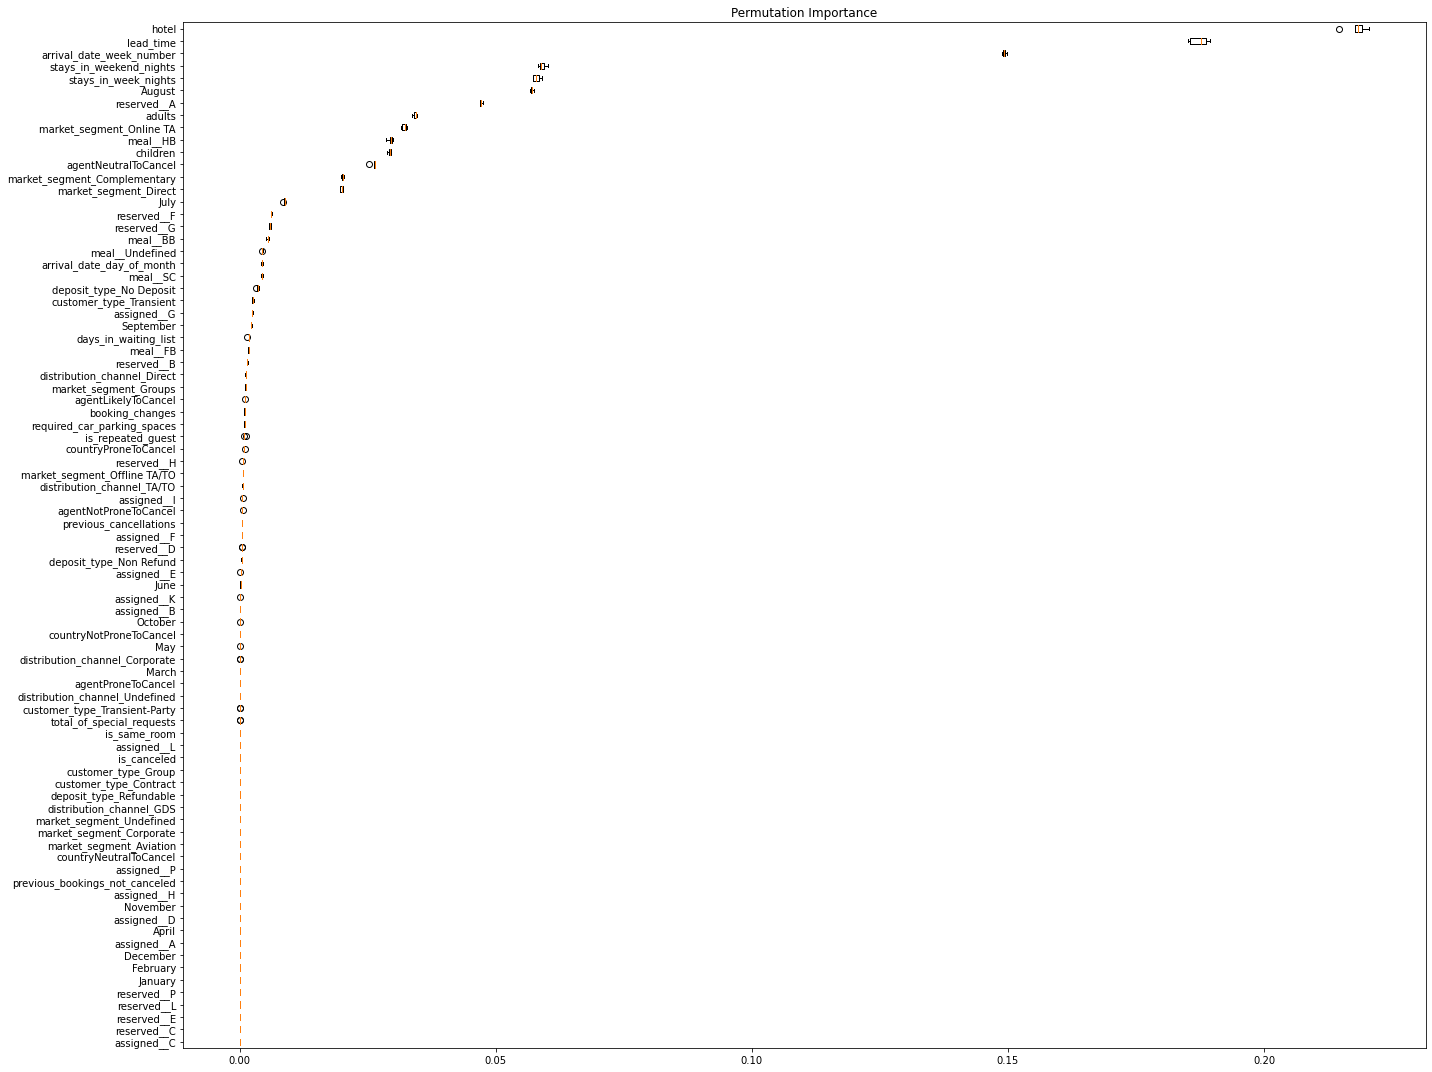

CPU times: user 11.3 s, sys: 1.08 s, total: 12.4 s
Wall time: 29.9 s


In [21]:
X_train, X_test, y_train, y_test = train_test_split(new_train_x, new_train_y, test_size=0.3)
model = XGBRegressor()
model = model.fit(X_train, y_train)
result = permutation_importance(model, X_train, y_train, scoring="r2", n_repeats=5, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(20, 15))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=traindf.drop("adr", axis=1).columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

In [27]:
traindf[["hotel", "adr"]].groupby("hotel").mean()

,adr
hotel,
0,69.139677
1,92.713942
